## **What is Logistic Regression?**

* Logistic regression is a statistical method used for binary classification problems, where the goal is to predict the probability that a given input belongs to one of two classes.
* Unlike linear regression, which predicts continuous outcomes, logistic regression uses the logistic function to predict the probability that the output will be equal to one based on the weights and bias learned from input data.

(Datatab, 2024)

###**0. Relevant Libraries**

* These are the libraries which I'll be using in this notebook.

* **For Installation**

In [1]:
try:
  import pyspark

except:
  %pip install pyspark
  import pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=455cf50c7a0b8411c020d4647b099cf9a4a9b1dfbfa6f50e113b96d18036795b
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


* **Standard Dependencies**

In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.display     import clear_output

plt.style.use('dark_background')

* ***scikit-learn* Dependencies**

In [3]:
from sklearn.preprocessing   import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

* ***PySpark* Dependencies**

In [4]:
import pyspark.sql.functions      as f
from pyspark                      import Row, SparkConf, SparkContext
from pyspark.sql                  import SQLContext, SparkSession
from pyspark.sql.functions        import *
from pyspark.sql.types            import *
from pyspark.sql.window           import Window
from pyspark.sql.pandas.functions import pandas_udf
from pyspark.ml.feature           import VectorAssembler, StringIndexer
from pyspark.ml.stat              import Correlation

###**1. PySpark Session**

* Initializing our Spark session

In [5]:
SPARK_CONF = SparkConf().set("spark.driver.host", "127.0.0.1")
SC         = SparkContext(conf = SPARK_CONF)
SPARK      = SparkSession.builder.getOrCreate()

SPARK

###**2. The Dataset**

* Loading our `.csv` data from GitHub to a Spark `DataFrame`.
* *Kaggle* source: https://www.kaggle.com/datasets/alexkataev/bank-marketing-data-set/data

In [6]:
DATA_URL = 'https://raw.githubusercontent.com/ST10437317/kpillay-firstrepo-vc/main/ST10437317_BANK_DATA.csv'
MY_DF    = SPARK.createDataFrame(pd.read_csv(DATA_URL, sep = ';'))

* **Our DataFrame**

  * The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution.
  * The classification goal is to predict if the client will subscribe a term deposit (variable `y`) based on the features.
  * The value of `y` is either '0' or '1' (these are binary labels).
  * Hence, logistic regression would be suitable for this dataset.

In [7]:
MY_DF.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.

* **Feature Description**

  1. `age`: how old is the client?
  
  2. `job`: what is the client's occupation?
  3. `marital`: is the client single or married?
  4. `education`: what is the client's highest level of education?
  5. `default`: does the client have credit in default? (reduces credit score)
  6. `housing`: does the client have a housing loan?
  7. `loan`: does the client have a personal loan?
  8. `contact`: what type of communication device does the client use?
  9. `month`: what was the last month the client was contacted?
  10. `day_of_week`: what day of the week was the client contacted?
  11. `duration`: how long was the phone call with the client?
  12. `campaign`: how many times was the client contacted during the campaign?
  13. `pdays`: how many days have passed since the client was last contacted?
  14. `previous`: how many times was the client contacted before the campaign?
  15. `poutcome`: what was the outcome of the previous marketing campaign?
  16. `emp.var.rate`: what is the current employment rate?
  17. `cons.price.idx`: measures the average prices of consumer goods and services
  18. `cons.conf.idx`: measures consumer optimism based on the current state of the economy or their personal financial situation.
  19. `euribor3m`: the interest rate where a group of banks lend one another funds
  20. `nr.employed`: what is the number of employed individuals in the economy?
  21. `y`: will the client subscribe to a deposit?

###**3. Data Preprocessing**

* Here, we are going to do some cleaning up.

* **Renaming Columns**

In [8]:
COLS = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

for C in range(len(COLS)):
  MY_DF = MY_DF.withColumnRenamed(COLS[C], COLS[C].replace(".", "_"))

* **Check schema**

  * Checking our datatypes

In [9]:
MY_DF.printSchema()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



* **Checking for Missing Values**

  * Ensure that there are no missing data values present.

In [10]:
MY_DF.select([count(when(isnull(C), C)).alias(C) for C in MY_DF.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



* **Checking Unique Values**


In [11]:
MY_DF.agg(*[f.countDistinct(c).alias(c) for c in MY_DF.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
| 78| 12|      4|        8|      3|      3|   3|      2|   10|          5|    1544|      42|   27|       8|       3|          10|            26|           26|      316|         11|  2|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



* **Checking for Duplicates**

In [12]:
COPIES = MY_DF.groupBy(MY_DF.columns).count().withColumn('# of Copies', col('count') - 1).agg({'# of Copies': 'sum'}).collect()[0][0]

print(f'Total number of sample copies (excluding the first instance): {COPIES} copies')

Total number of sample copies (excluding the first instance): 12 copies


* **Removing Duplicates**

  * There are 12 duplicate samples present, we need to remove them.


In [13]:
MY_DF  = MY_DF.dropDuplicates()
COPIES = MY_DF.groupBy(MY_DF.columns).count().withColumn('# of Copies', col('count') - 1).agg({'# of Copies': 'sum'}).collect()[0][0]

print(f'Total number of sample copies (excluding the first instance) after dropping duplicates: {COPIES} copies')

Total number of sample copies (excluding the first instance) after dropping duplicates: 0 copies


###**4. Data Visualisation**

* Here, we are going to be creating some plots which will enable us to explore and understand more about our data.



* **Bar Graphs**

  * Key Observations:

    * `job`
      * Most of the clients work in administration followed by blue-collar workers and technicians.

    * `marital`
      * Most of clients are married.

    * `education`
      * Most of the clients have a university degree

    * `default`, `housing` and `loan`
      * The majority of clients have a good credit score.
      * Most of the clients have taken loans.

    * `contact`, `month`, `day_of_week`, `poutcome`:
      * The previous campaign mostly did not have any recorded outcomes.
      * Most of the clients were contacted in May.

    * `emp.var.rate`
      * Most of clients were contacted when the employment variation rate increased by 1.4% for that quarter.

    * `cons.conf.idx`
      * This campaign seemed to be taking place in the midst of economic instability.

    * `cons.price.idx`
      * The prices of goods and services appear to fluctuate, during this time.

    * `nr.employed`
      * Many individuals were employed, during this campaign.
    * `y`
      * The target variable has a class imbalance ('no' is significantly more frequent than 'yes').
      * Most of the clients did not subscribe to a term deposit.

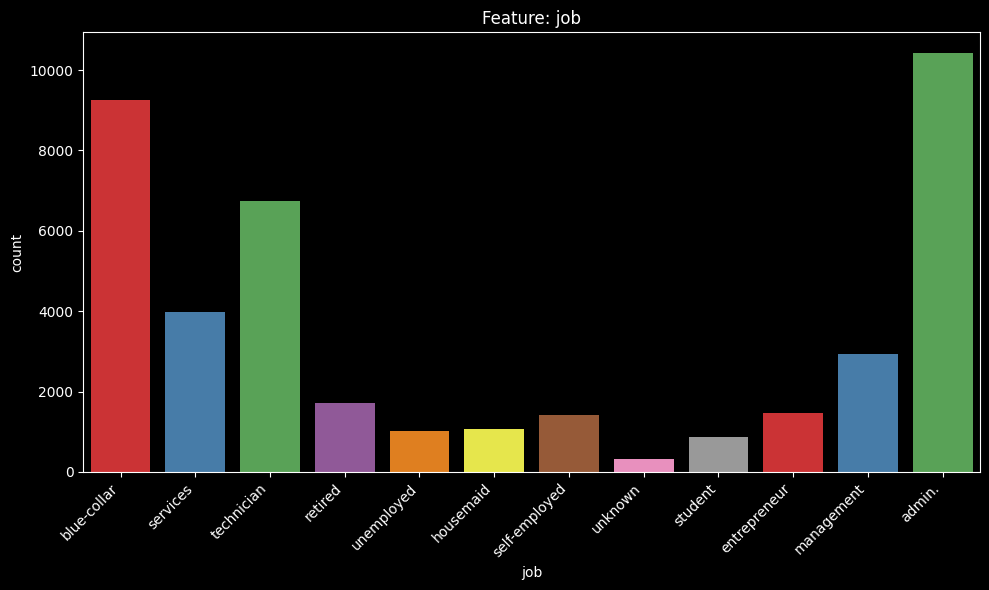

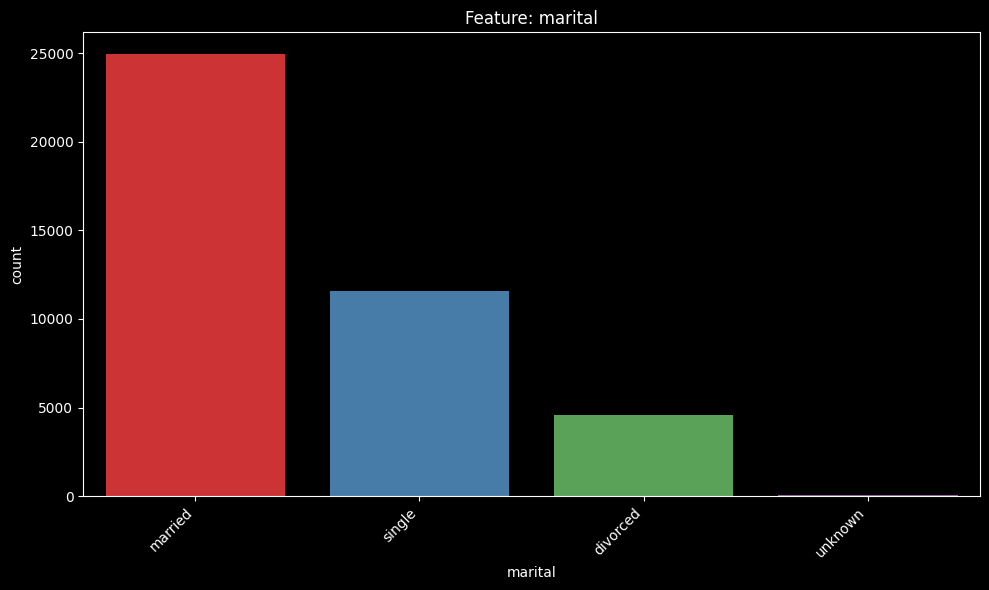

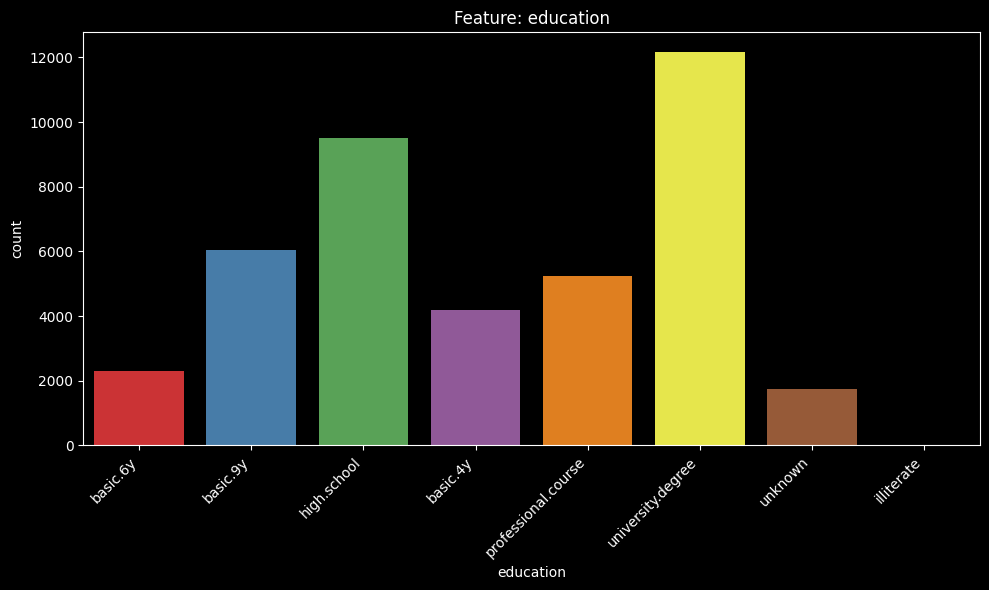

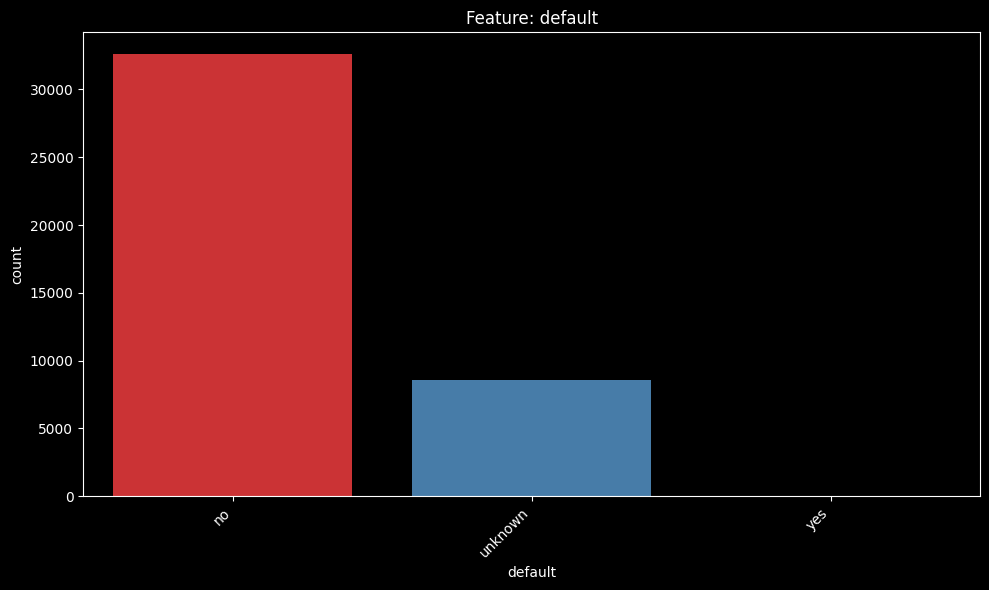

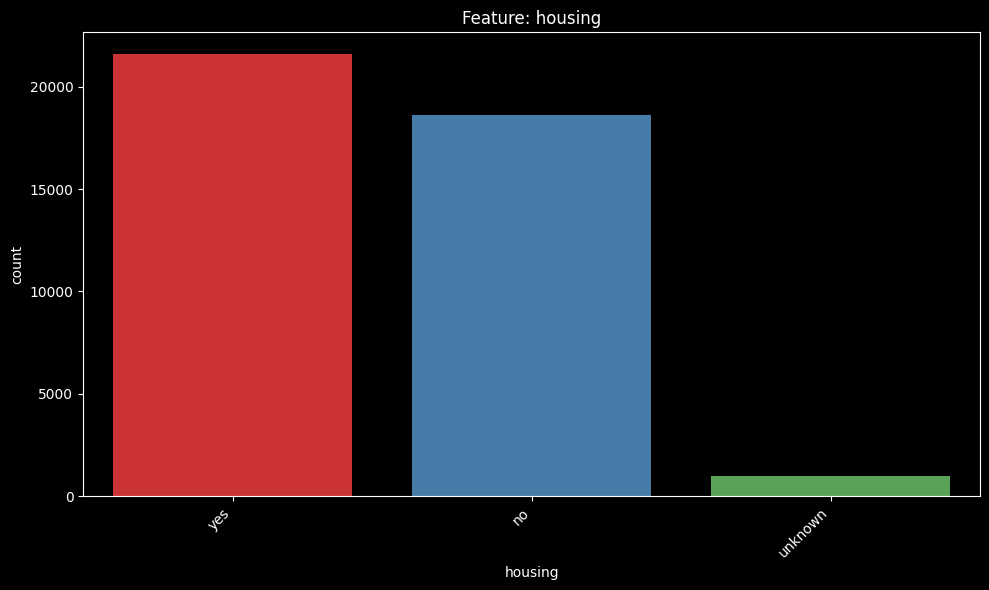

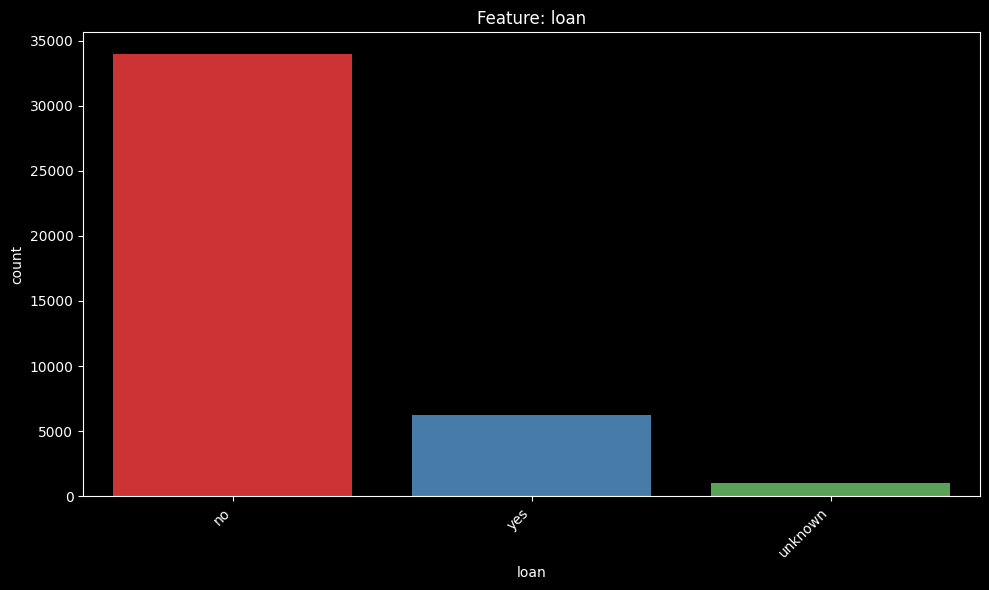

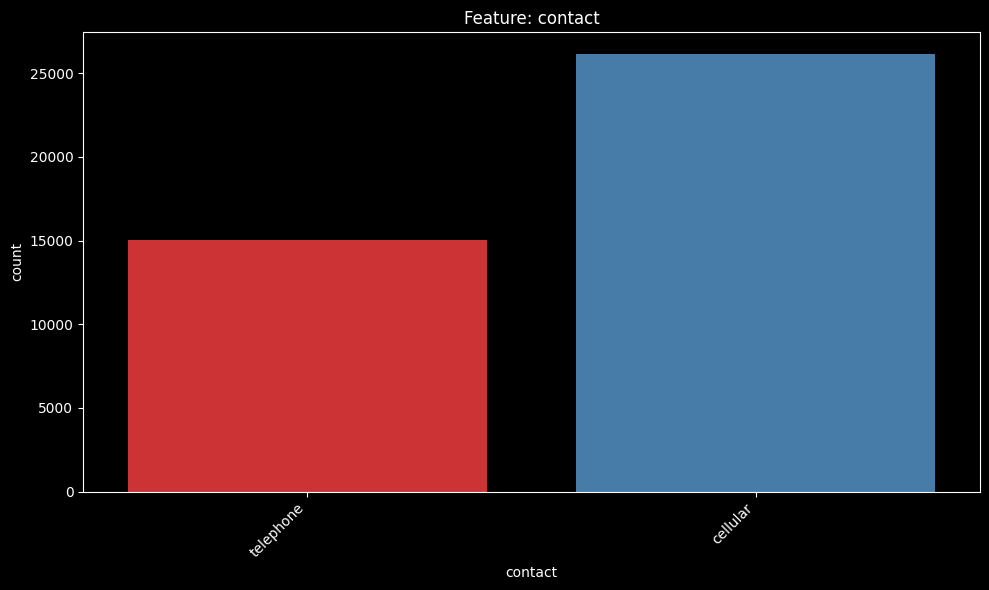

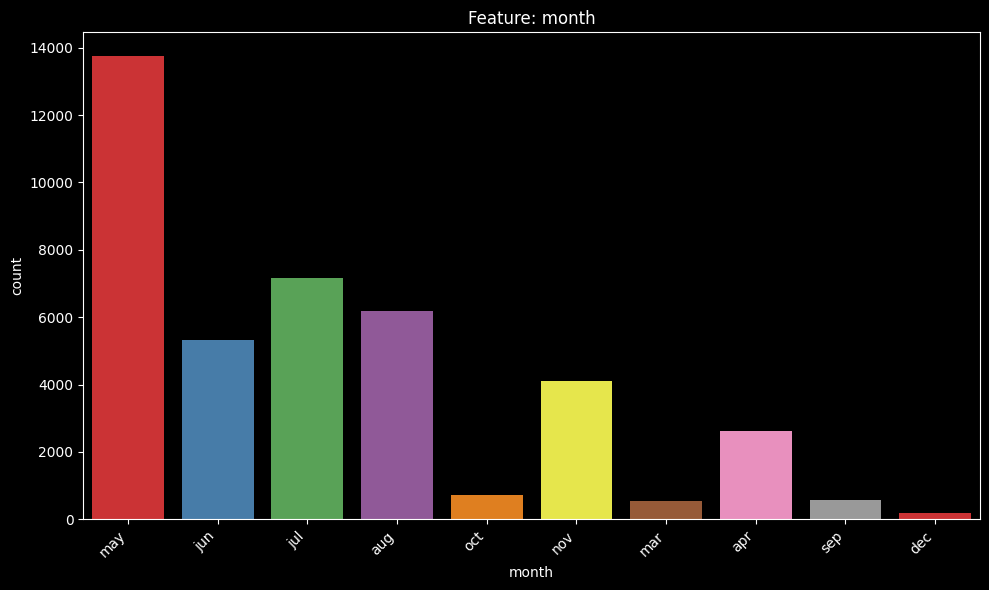

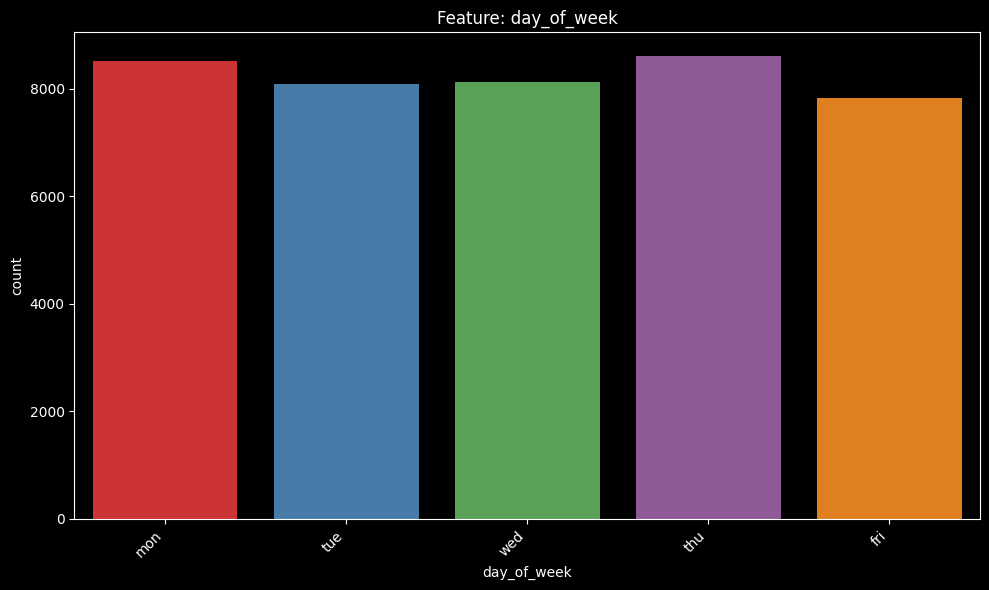

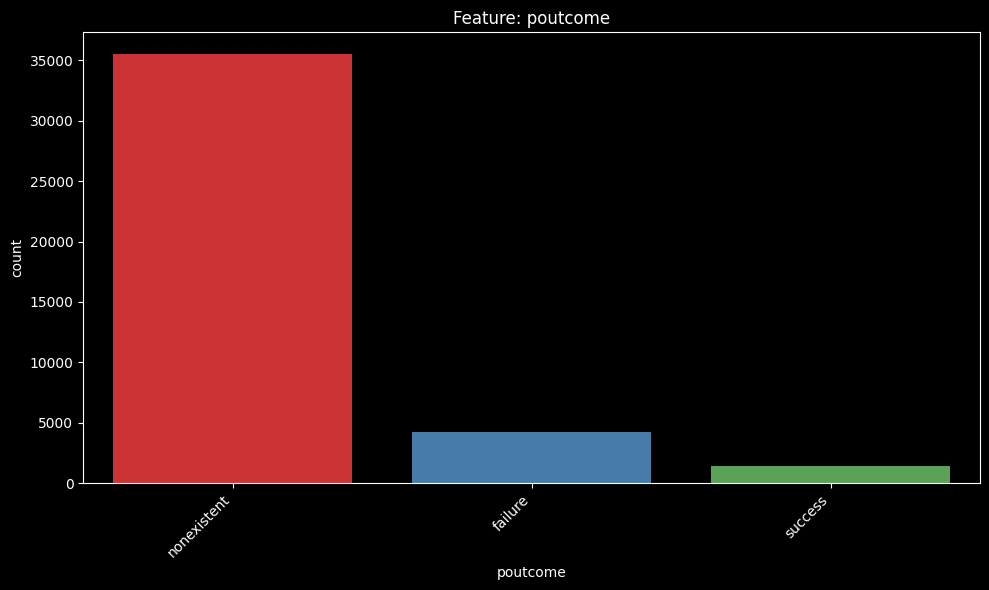

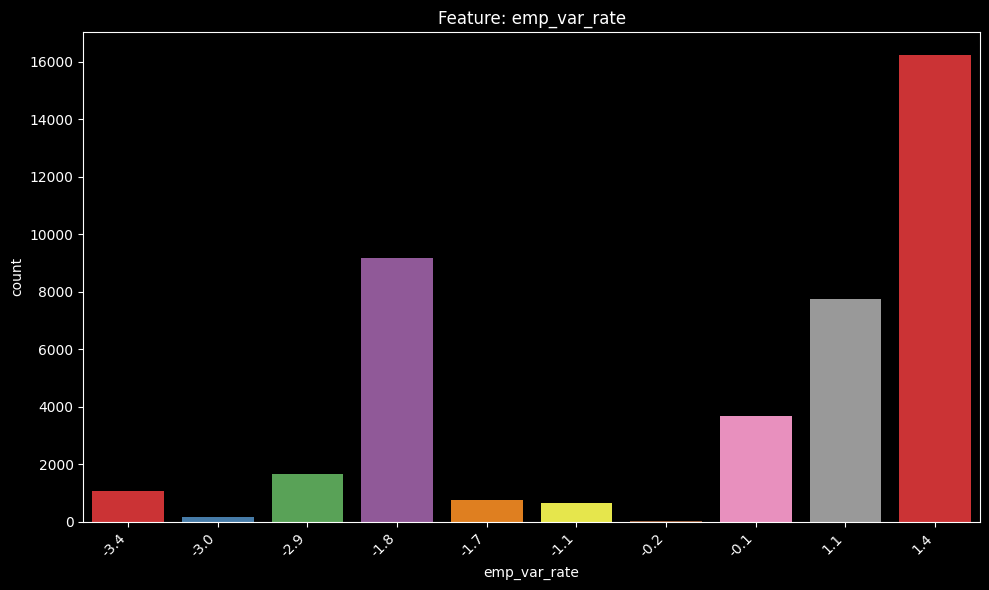

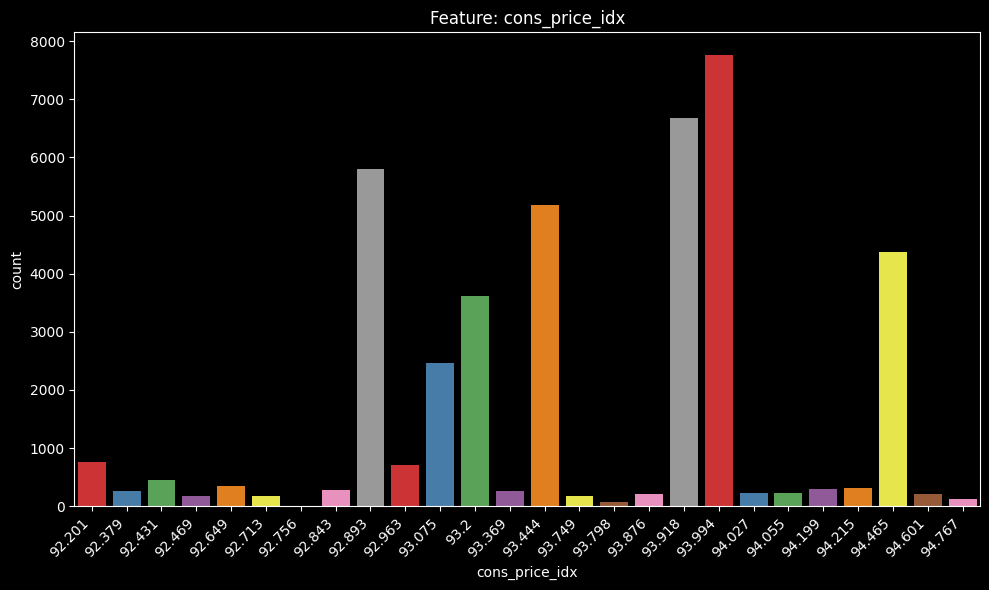

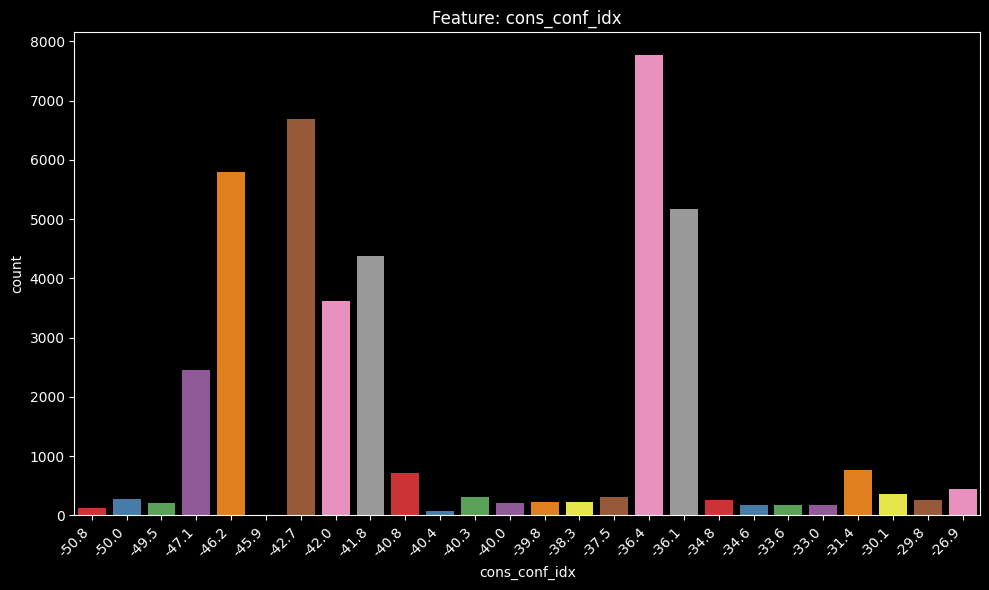

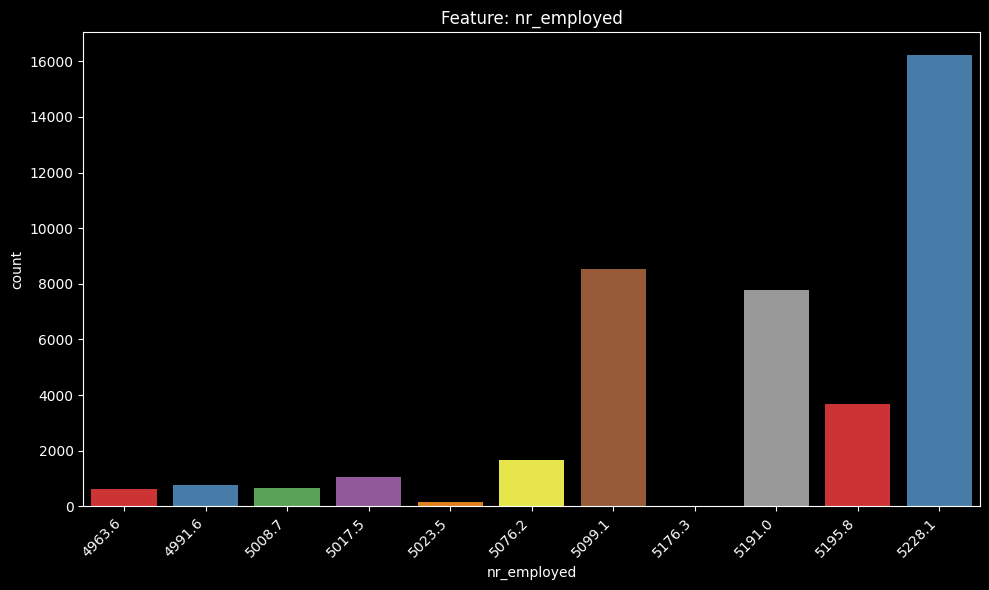

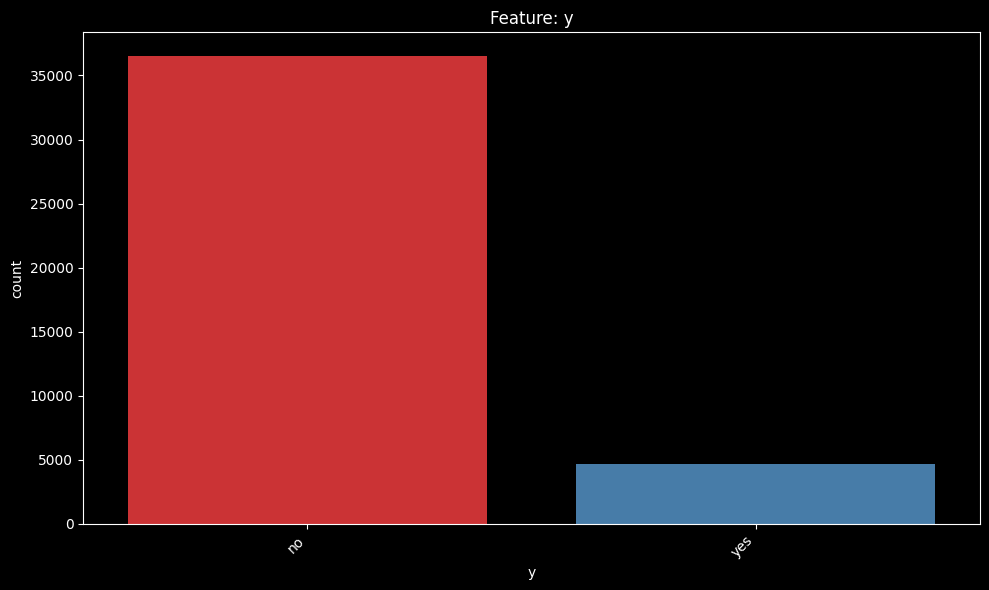

In [14]:
TEMP_DF      = MY_DF.toPandas().drop(['euribor3m'], axis = 1)
CATEGORICALS = TEMP_DF.select_dtypes(include = ['object', 'double']).columns

for COL in CATEGORICALS:
  plt.figure(figsize = (10, 6))
  ax = sns.countplot(x = COL, data = TEMP_DF, hue = COL, palette = 'Set1', legend = False)

  plt.xticks(rotation = 45, ha = 'right')
  plt.title('Feature: ' + COL)
  plt.tight_layout()
  plt.show()

* **Histograms**

  * `age`:
    * Appears to be slightly right-skewed.

    * This means that a larger portion of individuals in the dataset are younger, with a gradual decrease in frequency as age increases.
    * The peak of the distribution seems to be around the 30-40 age range.
      * This suggests that this age group is the most prevalent within the dataset.

  * `duration`:

    * Appears to be heavily right-skewed.
      * This indicates a large number of calls with shorter durations lasted much longer.
    
    * The peak of the distribution suggests that the most frequent call durations are relatively short.

    * There is a significant difference between the minimum and maximum call durations
      * This means that there is variability in call lengths.
      * The long tail indicates the presence of some extremely long calls, which could be potential outliers.

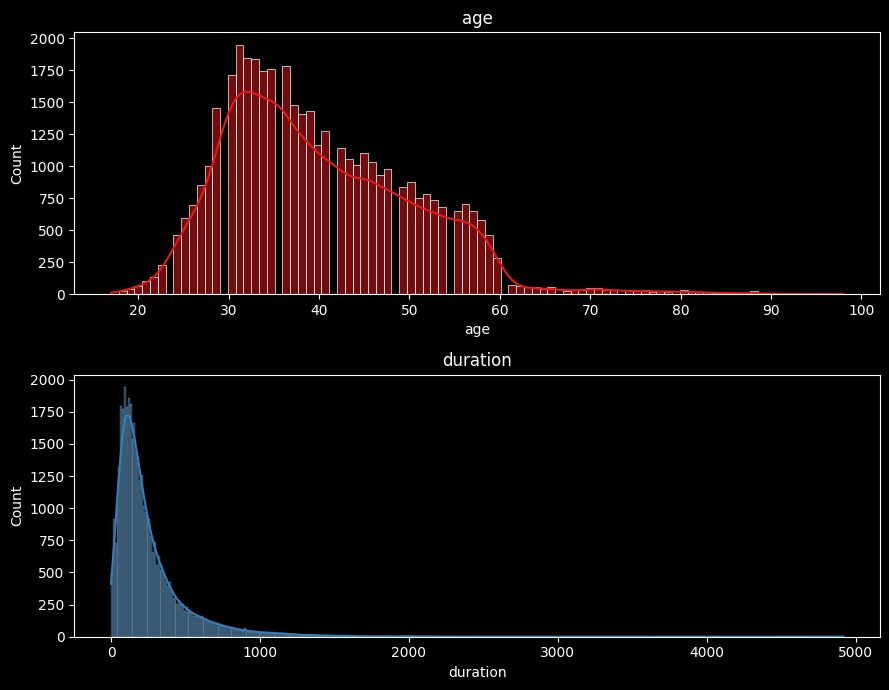

In [15]:
CONT_COLS = ['age', 'duration']

fig, axes = plt.subplots(len(CONT_COLS), 1, figsize = (9, 3.5 * len(CONT_COLS)))

for i, col in enumerate(CONT_COLS):
  TEMP = MY_DF.select(col).toPandas()

  sns.histplot(TEMP[col], kde = True, ax = axes[i], color = sns.color_palette('Set1', len(CONT_COLS))[i])
  axes[i].set_title(col)

plt.tight_layout()
plt.show()

###**5. Label Encoding**

* Numerically encode our non-numerical labels using the `StringIndexer` module from *TensorFlow*.

In [16]:
STRING_COLS = [c for c, t in MY_DF.dtypes if t.startswith('string')]

for COL in STRING_COLS:
  INDEXER = StringIndexer(inputCol = COL, outputCol = COL + "_index")
  MY_DF   = INDEXER.fit(MY_DF).transform(MY_DF)

for COL in STRING_COLS:
  MY_DF = MY_DF.drop(COL)

### **6. PySpark to Pandas Conversion**

* Below, is the final dataset which will be used to build our Logistic Regression model.

In [17]:
MY_DF = MY_DF.toPandas()
MY_DF = MY_DF.sample(frac = 1, random_state = 42).reset_index(drop = True)

MY_DF.head(20)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,marital_index,education_index,default_index,housing_index,loan_index,contact_index,month_index,day_of_week_index,poutcome_index,y_index
0,49,66,2,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,0.0,0.0
1,43,543,2,999,0,-1.8,92.893,-46.2,1.266,5099.1,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32,1239,1,999,0,-0.1,93.200,-42.0,4.406,5195.8,...,1.0,0.0,0.0,1.0,0.0,1.0,4.0,1.0,0.0,0.0
3,62,329,1,999,2,-1.1,94.767,-50.8,1.031,4963.6,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0
4,55,190,1,999,0,-1.8,92.893,-46.2,1.259,5099.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
5,39,59,5,999,0,1.4,93.918,-42.7,4.961,5228.1,...,0.0,5.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
6,37,202,2,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1.0,2.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0
7,48,158,2,999,0,1.1,93.994,-36.4,4.858,5191.0,...,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
8,29,128,2,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0
9,39,215,3,999,0,1.4,93.444,-36.1,4.966,5228.1,...,0.0,1.0,0.0,1.0,0.0,0.0,2.0,4.0,0.0,0.0


* **Final Dataset Check**

In [18]:
MY_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41176 non-null  int64  
 1   duration           41176 non-null  int64  
 2   campaign           41176 non-null  int64  
 3   pdays              41176 non-null  int64  
 4   previous           41176 non-null  int64  
 5   emp_var_rate       41176 non-null  float64
 6   cons_price_idx     41176 non-null  float64
 7   cons_conf_idx      41176 non-null  float64
 8   euribor3m          41176 non-null  float64
 9   nr_employed        41176 non-null  float64
 10  job_index          41176 non-null  float64
 11  marital_index      41176 non-null  float64
 12  education_index    41176 non-null  float64
 13  default_index      41176 non-null  float64
 14  housing_index      41176 non-null  float64
 15  loan_index         41176 non-null  float64
 16  contact_index      411

###**7. Feature Relationships**

* **Correlation Matrix**

  * Key Correlations

    1. `emp_var_rate` has a positive correlation with `cons_price_idx`, with a coefficient score of **0.78**.

    2. `poutcome_index` and `previous` have a positive correlation, with a coefficient score of **0.87**

    3. `emp_var_rate` and `nr_employed` have a positive correlation, with a coefficient score of **0.91**.

    4. `euribor3m` and `nr_employed` are positively correlated, with a coefficient score of **0.95**.

    5. `euribor3m` and `emp_var_rate` are positively correlated, with a coefficient score of **0.97**.

    6. `poutcome_index` and `pdays` have a negative correlation, with a coefficient score of **-0.74**.




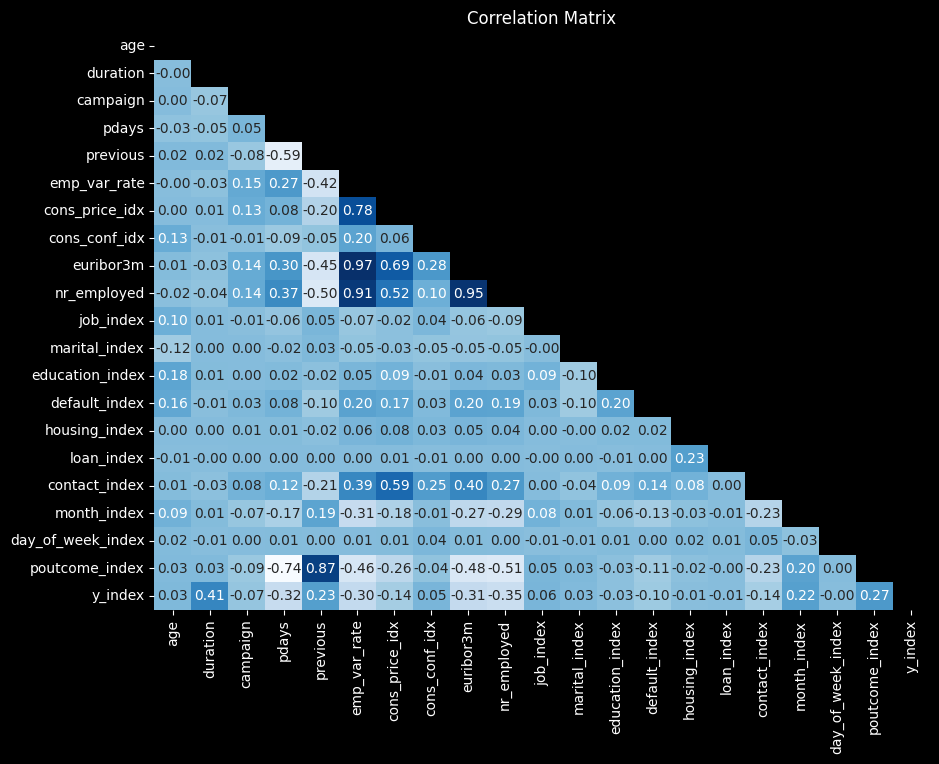

In [19]:
plt.figure(figsize = (10, 7.5))
sns.heatmap(MY_DF.corr(), annot = True, cmap = 'Blues', fmt =".2f", cbar = False, mask = np.triu(MY_DF.corr()))
plt.title('Correlation Matrix')
plt.show()

###**8. Train-Validation-Test Splits**

* I will be using the following proportions for my data splits.
  * 80% will be used for training.
  * 10% will be used for validation
  * 10% will be used for testing.

In [20]:
X      = MY_DF.drop('y_index', axis = 1)
y      = MY_DF['y_index']
SCALER = StandardScaler()

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state = 42, stratify = y_rest)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((32940, 20), (32940,), (4118, 20), (4118,), (4118, 20), (4118,))

* **Normalization**

  * We are going to apply the `StandardScaler` class to our data splits.
  * This will be used to standardize our data to ensure that the features have a similar range of values.
  * It does this by:
    * Centering each features' values around zero by subtracting the mean value from each data point.
    * Dividing each feature by its standard deviation value.

In [21]:
X_train = SCALER.fit_transform(X_train)
X_valid = SCALER.transform(X_valid)
X_test  = SCALER.transform(X_test)

pd.DataFrame(X_train).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.535354,0.318516,0.157519,0.196698,-0.352066,0.841257,1.539272,-0.283037,0.774380,0.847661,0.174538,0.702449,-0.480632,-0.515467,-0.914538,-0.438473,1.319773,0.540990,-0.674303,-0.374113
1,-0.293714,2.950620,-0.565086,-5.089396,1.682148,-2.206965,-1.596058,2.239253,-1.665077,-2.061778,1.650888,-0.732774,0.653588,-0.515467,-0.914538,1.755890,-0.757706,1.045326,-0.674303,3.998171
2,-0.102693,1.251121,1.241425,0.196698,-0.352066,0.650743,0.726089,0.881097,0.715092,0.335124,-0.932725,-0.732774,-1.047741,-0.515467,0.917987,-0.438473,1.319773,-0.972019,-0.674303,-0.374113
3,0.947925,0.014070,0.518821,0.196698,-0.352066,0.841257,0.594874,-0.477059,0.774380,0.847661,1.281800,-0.732774,0.086478,1.938570,0.917987,-0.438473,-0.757706,-0.467682,-0.674303,-0.374113
4,-0.293714,-0.429110,-0.203784,0.196698,-0.352066,0.841257,0.594874,-0.477059,0.773229,0.847661,-0.563637,-0.732774,1.220698,-0.515467,0.917987,-0.438473,-0.757706,-0.467682,-1.381272,-0.374113
5,-0.866779,-0.194032,0.518821,0.196698,-0.352066,0.841257,-0.223488,0.945771,0.776683,0.847661,2.019975,-0.732774,-1.047741,-0.515467,-0.914538,1.755890,-0.757706,0.036654,-1.381272,-0.374113
6,1.807521,-0.371304,-0.565086,0.196698,-0.352066,0.650743,0.726089,0.881097,0.716243,0.335124,-0.563637,-0.732774,1.220698,-0.515467,-0.914538,-0.438473,1.319773,-0.972019,0.032666,-0.374113
7,0.947925,-0.644919,-0.565086,0.196698,-0.352066,0.841257,1.539272,-0.283037,0.778410,0.847661,-0.563637,-0.732774,1.220698,1.938570,-0.914538,-0.438473,1.319773,0.540990,1.446604,-0.374113
8,1.043436,0.291539,-0.203784,0.196698,-0.352066,0.841257,1.539272,-0.283037,0.774956,0.847661,-0.563637,-0.732774,1.220698,1.938570,-0.914538,-0.438473,1.319773,0.540990,0.739635,-0.374113
9,0.279350,0.017924,0.518821,0.196698,-0.352066,-1.190891,0.303095,1.269142,-1.709399,-2.183350,-0.932725,2.137673,-1.047741,-0.515467,0.917987,-0.438473,1.319773,1.549663,1.446604,-0.374113


###**9. Logistic Regression Implementation (Step by Step)**

  1. The `__init__()` method will called to create an instance of our logistic regression model after the following parameters are initialized:

    *  `LEARNING_RATE`: controls by how much the weights should be adjusted.

    * `N_ITERS`: states how many times the weights should be adjusted or updated.
    * `WEIGHTS` and `BIAS`: these are the values that our model plans to learn.
    * `LOSSES`: a list used to store the loss values at specific intervals.

  2. The `_SIGMOID()` method will be used to map an input (`X`) to a floating-point value between `0.0` and `1.0`, which represents the probability of a class or label.

  3. The `COMPUTE_LOSS()` method will use the binary cross-entropy formula to measure how well the predicted values match the actual values.

  4. The `FEED_FORWARD()` method will perform a linear regression calculation which multiplies the feature values (`X`) by the weights and then offset by the bias value to output a weighted sum, which will finally be passed to the `SIGMOID()` method to get the prediction probabilities.

  5. The `PREDICT()` method will:
    * Call the `FEED_FORWARD()` method to calculate the prediction probabilities.
    * Convert the probabilities to either `0` or `1` based on whether the value is above or below the threshold value of `0.5`

  6. The `FIT()` method will use a process called gradient descent to fit the data points, where for every iteration:
    * The prediction probabilities are calculated represented by `A`.
    * The BCE loss is calculated and stored.
    * Variable `DZ` refers to the gradient, which tells us how much to adjust the weights.
    * The gradient is calculated for each `DW` (weights) and `DB` (bias) value.
    * The weights and bias are updated until they yield the lowest loss value possible.



In [22]:
class ScratchyLogisticRegression:
  def __init__(self, LEARNING_RATE = 0.001, N_ITERS = 1000):
    self.LR      = LEARNING_RATE
    self.N_ITERS = N_ITERS
    self.WEIGHTS = None
    self.BIAS    = None
    self.LOSSES  = []

  def _SIGMOID(self, X):
    clear_output(wait = True)

    return 1 / (1 + np.exp(-X))

  def COMPUTE_LOSS(self, Y_TRUE, Y_PRED):
    EPSILON = 1e-9
    Y1      = Y_TRUE * np.log(Y_PRED + EPSILON)
    Y2      = (1 - Y_TRUE) * np.log(1 - Y_PRED + EPSILON)

    return -np.mean(Y1 + Y2)

  def FEED_FORWARD(self, X):
    Z = np.dot(X, self.WEIGHTS) + self.BIAS
    A = self._SIGMOID(Z)

    return A

  def PREDICT(self, X):
    THRESHOLD       = 0.5
    Y_PREDICTED     = self.FEED_FORWARD(X)
    Y_PREDICTED_CLS = [1 if I > THRESHOLD else 0 for I in Y_PREDICTED]

    return np.array(Y_PREDICTED_CLS)

  def FIT(self, X, Y):
    ACCURACIES            = []
    LOSSES                = []
    ITERATION_POINTS      = []
    N_SAMPLES, N_FEATURES = X.shape
    self.WEIGHTS          = np.zeros(N_FEATURES)
    self.BIAS             = 0

    for I in range(self.N_ITERS):
      A = self.FEED_FORWARD(X)

      if (I + 1) % 100 == 0:
        LOSSES.append(self.COMPUTE_LOSS(Y, A))
        ITERATION_POINTS.append(I + 1)

      DZ =  A - Y
      DW = (1 / N_SAMPLES) * np.dot(X.T, DZ)
      DB = (1 / N_SAMPLES) * np.sum(DZ)

      self.WEIGHTS -= self.LR * DW
      self.BIAS    -= self.LR * DB

      if (I + 1) % 100 == 0:
        Y_PRED   = self.PREDICT(X)
        ACCURACY = accuracy_score(Y, Y_PRED)

        ACCURACIES.append(ACCURACY)

    clear_output(wait = True)
    print('Training Completed.')

    fig, axes = plt.subplots(2, 1, figsize = (8, 6))
    fig.suptitle('Training Log', fontsize = 13.5)

    axes[0].plot(range(100, self.N_ITERS + 1, 100), ACCURACIES, marker = 'o', linestyle = '-', color = 'green')
    axes[0].set_xlabel('Iterations (#)')
    axes[0].set_ylabel('Accuracy Factor')
    axes[0].set_title('Accuracy')

    axes[1].plot(ITERATION_POINTS, LOSSES, marker = 'o', linestyle = '-', color = 'red')
    axes[1].set_xlabel('Iterations (#)')
    axes[1].set_ylabel('Loss Factor')
    axes[1].set_title('BCE Loss')

    plt.tight_layout()
    plt.show()

    print(f'Training Accuracy: {np.round(ACCURACIES[-1], 3) * 100}%')
    print(f'Training Loss:     {np.round(LOSSES[-1], 3)}')

* **Model Instance, Fitting and Experimentation**

  * Here, we are going to try out two models: one with a learning rate of `0.001` and one with a learning rate of `0.01`.
  * Let's see which one performs better, in terms of training accuracy and loss.

  * `LR_MODEL_1`

    * The default learning rate is set to `0.001` and `1000` iterations.
    * This model performed pretty well based on the numbers.
    * Can it do better using a different learning rate?
      * Let's make a second model.

Training Completed.


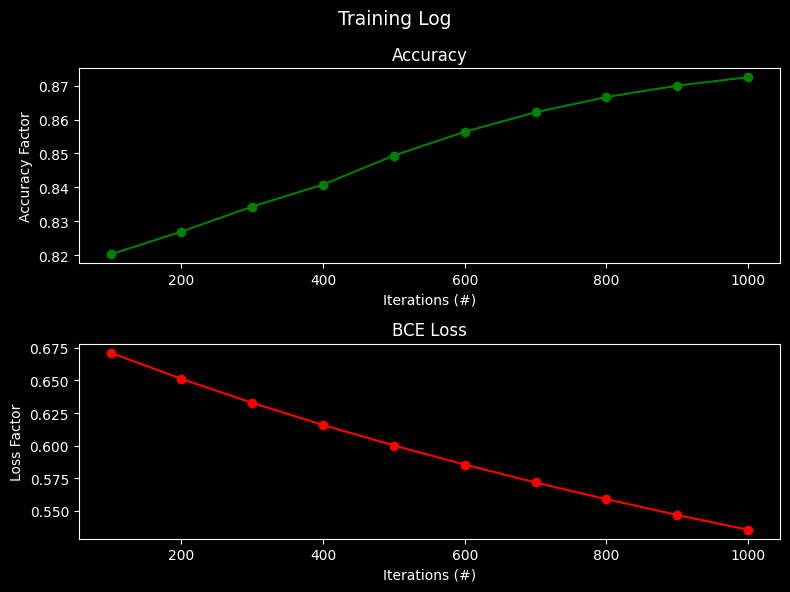

Training Accuracy: 87.3%
Training Loss:     0.535


In [23]:
LR_MODEL_1 = ScratchyLogisticRegression()

LR_MODEL_1.FIT(X_train, y_train)

* `LR_MODEL_2`

  * The learning rate is set to `0.01` for this model.
  * The number of iterations is the same as the first model.
  * This is the better performing model, based on the difference in accuracy and BCE loss compared to the first model.

Training Completed.


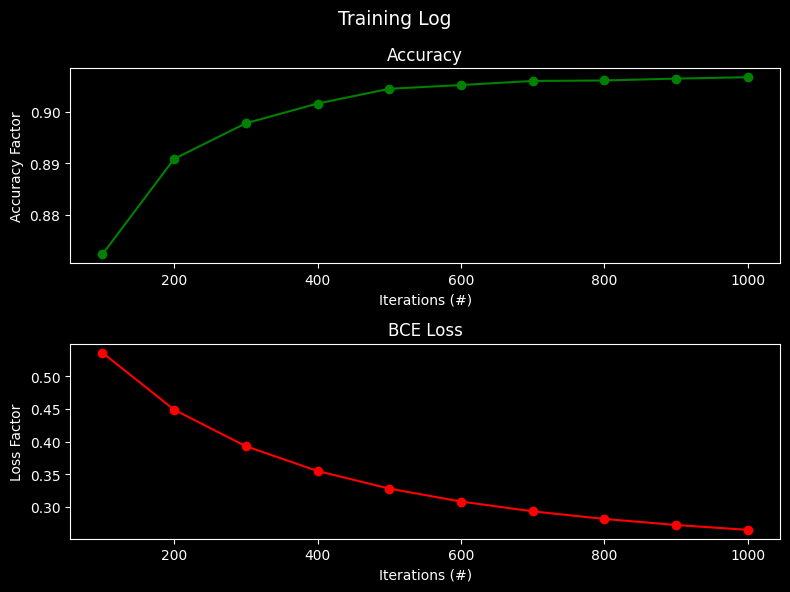

Training Accuracy: 90.7%
Training Loss:     0.265


In [24]:
LR_MODEL_2 = ScratchyLogisticRegression(LEARNING_RATE = 0.01)

LR_MODEL_2.FIT(X_train, y_train)

###**10. Performance Evaluation**

* **Classification Metrics**

  1. `precision`
    * Measures the accuracy of positive predictions.

  2. `recall`
    * Measures the ability of the model to identify all positive instances.

  3. `f1-score`
    * The harmonic mean of precision and recall, providing a balanced measure of the model's performance.

  4. `support`
    * The number of instances of each class in the dataset.

  5. `accuracy`
    * The overall proportion of correctly classified instances.

  6. `macro avg`
    * The average of the metrics across all classes, giving equal weight to each class.

  7. `weighted avg`
    * The average of the metrics across all classes, weighted by the number of instances in each class.



* **Validation Report**


In [25]:
Y_PREDS_VALID = LR_MODEL_2.PREDICT(X_valid)

print(classification_report(y_valid, Y_PREDS_VALID))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      3654
         1.0       0.68      0.35      0.46       464

    accuracy                           0.91      4118
   macro avg       0.80      0.67      0.71      4118
weighted avg       0.90      0.91      0.90      4118



* **Test Report**

In [26]:
Y_PREDS_TEST = LR_MODEL_2.PREDICT(X_test)

print(classification_report(y_test, Y_PREDS_TEST))

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      3654
         1.0       0.68      0.39      0.50       464

    accuracy                           0.91      4118
   macro avg       0.80      0.68      0.72      4118
weighted avg       0.90      0.91      0.90      4118



* **Confusion Matrices**

  * The confusion matrices our the model's performance on the validation and test sets.
  * Each row of the matrix represents the actual class, while each column represents the predicted class.


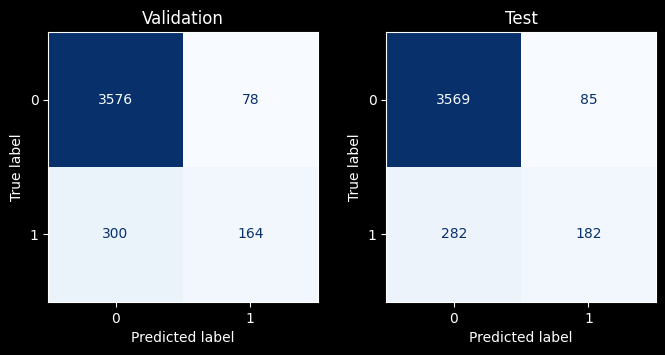

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3.5))

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_valid, Y_PREDS_VALID)).plot(ax = ax1, colorbar = False, cmap = 'Blues')
ax1.set_title('Validation')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, Y_PREDS_TEST)).plot(ax = ax2, colorbar = False, cmap = 'Blues')
ax2.set_title('Test')

plt.show()

* **Final Judgement**

  * The model exhibits consistent performance across both validation and testing sets.

  * This is evident in the similar accuracy scores (0.91) and classification metrics in both reports.
  * The confusion matrices visually support this observation, showing similar patterns of predictions for both sets.

  * The model excels at predicting the majority class (clients who did not subscribe or '0'), as demonstrated by high precision, recall and a large number of true negatives (TN) in the confusion matrices.

  * Conversely, the model struggles with the minority class (clients who did subscribe or '1'), reflected in lower precision, recall and a smaller number of true positives (TP) in the confusion matrices.
    * This suggests a class imbalance issue.

* **Overall Conclusion:**

  * Despite the class imbalance, the Logistic Regression model provides a decent baseline for predicting term deposit subscriptions.


###**11. PySpark End**

* End our *Spark* session.

In [28]:
SPARK.stop()

### **12. References**

  Datatab, 2024. Logistic Regression. [Online]
Available at: https://datatab.net/tutorial/logistic-regression
[Accessed 12 October 2024].

